In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from datastore import DataStore

from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
data = pd.read_csv('data/adj_close.csv', index_col="Date", parse_dates=["Date"])

In [3]:
data.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.609097,35.305672,41.206989,9.244411,16.633608,9.35,10.491420,22.193466,38.520000,25.182011,...,29.771486,10.504530,18.621290,37.851017,24.792299,32.808895,11.401830,63.671101,42.830002,62.799614
2006-01-04,20.664463,36.955460,41.500534,9.271619,16.523405,9.62,10.507332,22.314663,38.419998,25.415308,...,29.716314,10.555444,19.459511,37.915764,25.021738,32.764881,11.499380,64.275429,42.410000,63.243000
2006-01-05,21.205837,37.436264,41.699368,9.198654,16.318720,9.55,10.642622,22.481304,38.070000,26.224972,...,29.539719,10.549784,20.630112,37.728016,24.737236,32.412811,11.989601,63.596718,42.529999,63.817776
2006-01-06,21.316574,36.766911,41.652027,9.436100,16.137671,9.75,10.846883,23.594763,39.000000,26.327896,...,29.821154,10.589380,21.041996,38.472500,25.122686,32.214756,11.955452,63.271294,44.119999,64.482903
2006-01-09,21.255054,36.399246,42.191738,9.405183,16.137671,10.15,11.250092,23.526592,38.380001,26.698418,...,31.228340,10.561097,21.020315,38.453083,25.370464,32.654846,12.048132,65.512039,44.790001,63.949154


In [4]:
# Select stocks corss multiple sectors:
# Communications: "DIS", "CMCSA"
# Technology: "MSFT", "GOOGL", "AAPL", "IBM", "CSCO"
# Financials: "JPM", "GS"
# Industrials: "BA", "LMT"
tickers = ["DIS", "CMCSA", "MSFT", "GOOGL", "AAPL", "IBM", "CSCO", "JPM", "GS", "BA", "LMT"]

valid_size = 0.15            # proportion of dataset to be used as validation set
test_size = 0.1              # proportion of dataset to be used as test set
lookback = 40                # Number of days to lookback
lookahead_list = [1, 3, 7]   # List of lookahead days
data_dir = 'data/'

Now we create the DataStore object and call its member function save_train_valid_to_csv to generate model ready data.

In [5]:
ds = DataStore(data, tickers, valid_size, test_size, lookback, lookahead_list)

In [6]:
ds.save_train_valid_to_csv(tickers, data_dir)

In [7]:
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=200)

Text(0.5, 1.0, 'Normalized Closing Stock Price')

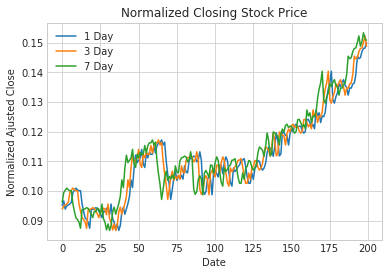

In [8]:
plt.plot(train_sample.iloc[:, 0])
plt.plot(train_sample.iloc[:, 1])
plt.plot(train_sample.iloc[:, 2])
plt.ylabel("Normalized Ajusted Close")
plt.xlabel("Date")
plt.legend(["1 Day", "3 Day", "7 Day"])
plt.title("Normalized Closing Stock Price")

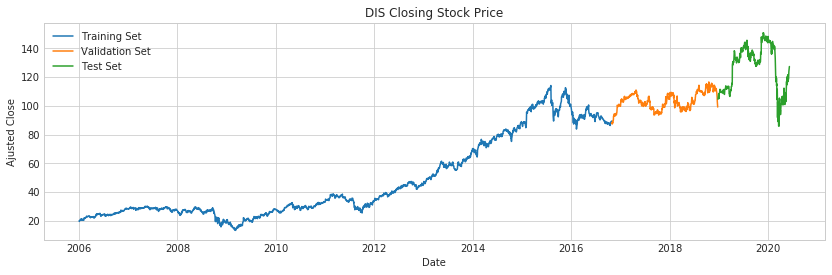

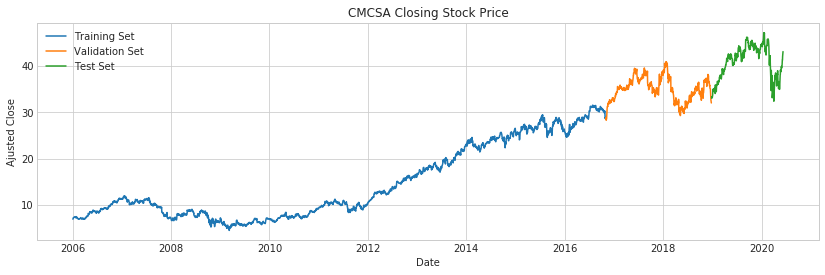

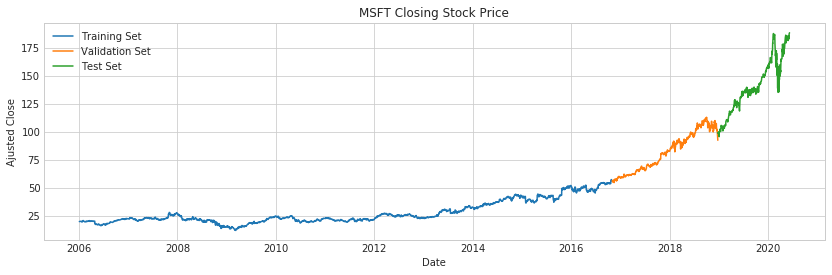

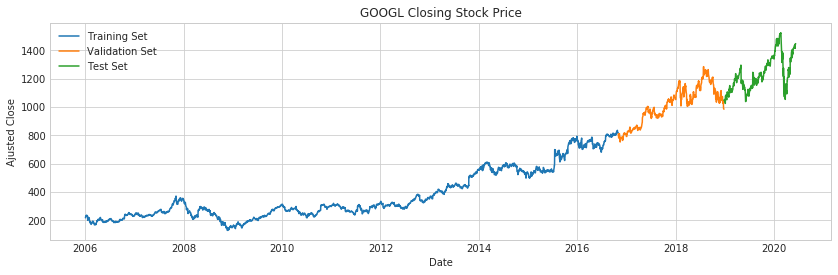

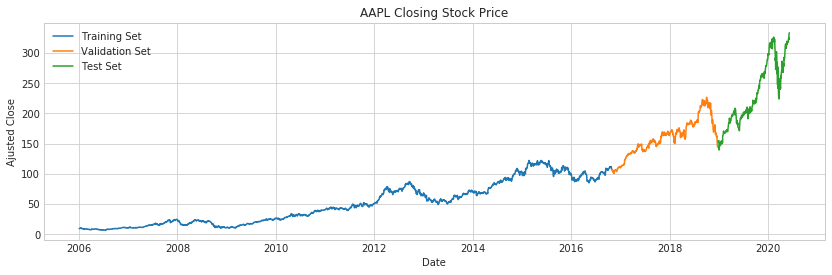

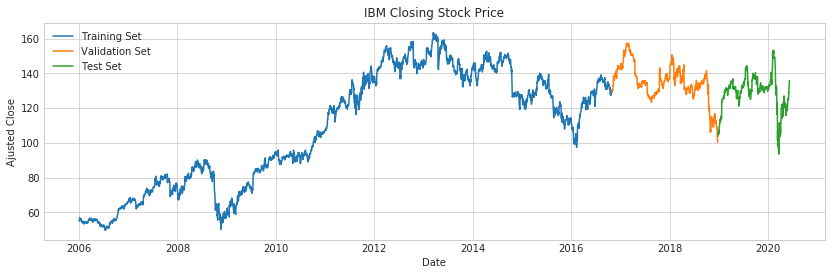

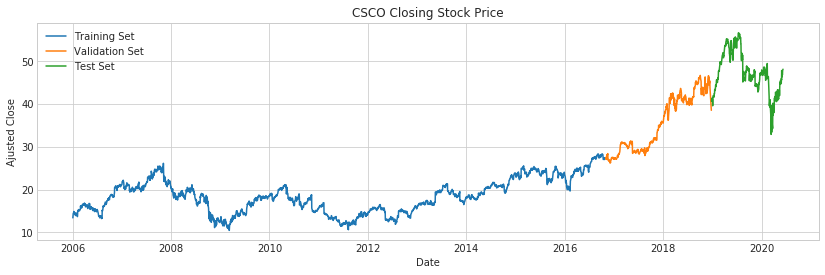

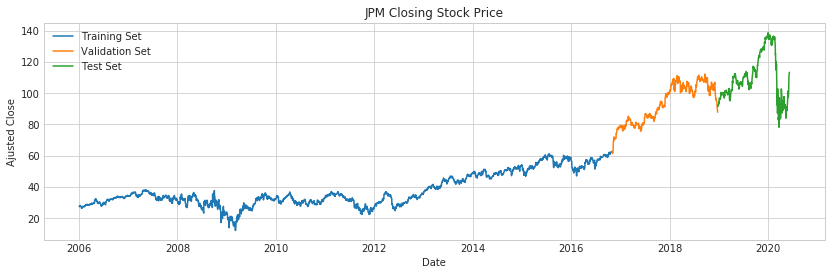

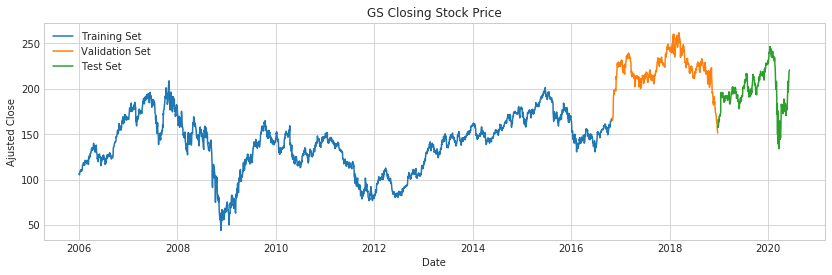

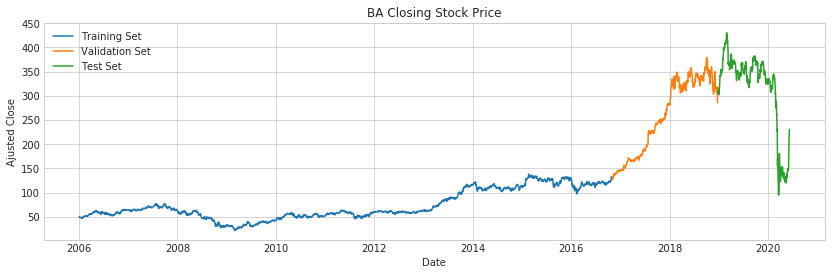

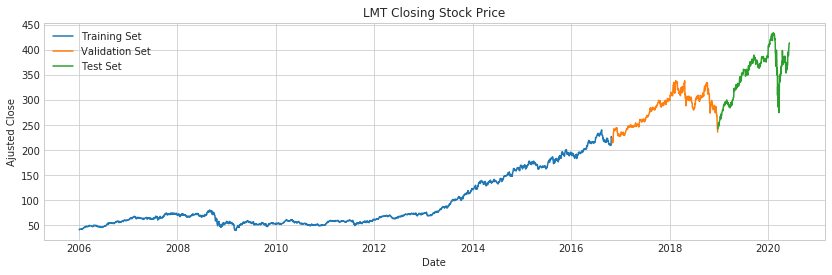

In [9]:
ds.plot(tickers)

### Now we have all data has been preprocessed. We are ready to train our model.

In [10]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock_prediction'

role = sagemaker.get_execution_role()

In [11]:
# upload train/validation data to S3
input_data = sagemaker_session.upload_data(data_dir, key_prefix=prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


In [12]:
!pygmentize train/model.py

import torch.nn as nn

class StockPredictor(nn.Module):
    """
    This is the simple RNN model we will be using to perform Stock Prediction.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers, lstm_dropout = 0.2, fc_dropout = 0):
        """
        Initialize the model by setting up the various layers.
        
            Parameters:
            -----------
            input_size   : The number of expected features in the input.
                           The input is a sequence.
                           "input_size" specifies the dimension of each data point in the sequence.
            hidden_size  : The number of features in the hidden state.
            output_size  : The dimension of output
            num_layers   : The number of stacked LSTM layers
            lstm_dropout : Drop out for each LSTM layer except the last layer 
                           with probability equal to dropout
            fc_dropout   : Drop out probability for the fi

In [13]:
from sagemaker.pytorch import PyTorch

lstm  = PyTorch(entry_point="train.py",
                source_dir="train",
                role=role,
                framework_version='0.4.0',
                train_instance_count=1,
                train_instance_type='ml.p2.xlarge', # Change back to ml.p2.xlarge
                hyperparameters={
                    'input_size': 1,
                    'hidden_size': 128,
                    'output_size': len(lookahead_list),
                    'num_layers': 1,
                    'lstm_dropout': 0.2,
                    'fc_dropout': 0.1,
                    'epochs': 100,
                    'lr': 0.001
                })

In [16]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner

objective_metric_name = 'Average Validation loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'Average Validation loss',
                       'Regex': 'VALIDATION_LOSS=([0-9\\.]+)'}]

lstm_hyperparameter_tuner = HyperparameterTuner(estimator = lstm, # The estimator object to use as the basis for the training jobs.
                                                objective_metric_name = objective_metric_name,
                                                objective_type = objective_type, 
                                                metric_definitions = metric_definitions,
                                                max_jobs = 30, # The total number of models to train
                                                max_parallel_jobs = 1, # The number of models to train in parallel
                                                early_stopping_type = 'Auto',
                                                hyperparameter_ranges = {
                                                     'lr'          : ContinuousParameter(0.001, 0.015),
                                                     'hidden_size' : CategoricalParameter([32, 128, 256]),
                                                     'lstm_dropout': CategoricalParameter([0, 0.2]),
                                                     'fc_dropout'  : CategoricalParameter([0, 0.1]),
                                                     'num_layers'  : IntegerParameter(1, 4)
                                                })

In [17]:
lstm_hyperparameter_tuner.fit({'train': input_data})

In [18]:
lstm_hyperparameter_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
lstm_hyperparameter_tuner.best_training_job()

'sagemaker-pytorch-200615-2147-014-b3dc0f46'

In [22]:
best_lstm = sagemaker.estimator.Estimator.attach(lstm_hyperparameter_tuner.best_training_job())

2020-06-15 23:56:31 Starting - Preparing the instances for training
2020-06-15 23:56:31 Downloading - Downloading input data
2020-06-15 23:56:31 Training - Training image download completed. Training in progress.
2020-06-15 23:56:31 Uploading - Uploading generated training model
2020-06-15 23:56:31 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-15 23:50:03,110 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-15 23:50:03,111 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value Average Validation loss to Json.
Returning the value itself
2020-06-15 23:50:03,135 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-15 23:50:06,175 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-15 23:50:06,467 sagemaker-containers INFO     M

##### Attaching the best model somehow failed the deployment. Therefore, I re-train the model in the underlying kernel with the best model's hyperparameters.

In [14]:
lstm  = PyTorch(entry_point="train.py",
                source_dir="train",
                role=role,
                framework_version='0.4.0',
                train_instance_count=1,
                train_instance_type='ml.p2.xlarge', # Change back to ml.p2.xlarge
                hyperparameters={
                    'input_size': 1,
                    'hidden_size': 32,
                    'output_size': len(lookahead_list),
                    'num_layers': 3,
                    'lstm_dropout': 0.2,
                    'fc_dropout': 0,
                    'epochs': 100,
                    'lr': 0.0023
                })

In [15]:
%%time

lstm.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-16 04:24:33 Starting - Starting the training job...
2020-06-16 04:24:35 Starting - Launching requested ML instances......
2020-06-16 04:25:37 Starting - Preparing the instances for training......
2020-06-16 04:26:53 Downloading - Downloading input data...
2020-06-16 04:27:27 Training - Downloading the training image...
2020-06-16 04:27:57 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-16 04:27:58,534 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-16 04:27:58,558 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-16 04:28:04,822 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-16 04:28:05,101 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-06-16 04:28:05,101 sagemak

Epoch: 2, MSELoss: 0.011442343775588842
VALIDATION_LOSS=0.0086
Epoch: 3, MSELoss: 0.006614447911537404
VALIDATION_LOSS=0.0073
Epoch: 4, MSELoss: 0.005179256011615507
VALIDATION_LOSS=0.0071
Epoch: 5, MSELoss: 0.0024410930544380223
VALIDATION_LOSS=0.0063
Epoch: 6, MSELoss: 0.003783100843803196
VALIDATION_LOSS=0.0128
Epoch: 7, MSELoss: 0.006930732205226967
VALIDATION_LOSS=0.0054
Epoch: 8, MSELoss: 0.0026597978524207705
VALIDATION_LOSS=0.0056
Epoch: 9, MSELoss: 0.00473135775226527
VALIDATION_LOSS=0.0051
Epoch: 10, MSELoss: 0.0017843383295159485
VALIDATION_LOSS=0.0052
Epoch: 11, MSELoss: 0.004978856231507569
VALIDATION_LOSS=0.0049
Epoch: 12, MSELoss: 0.0020557271434242736
VALIDATION_LOSS=0.0049
Epoch: 13, MSELoss: 0.005013152400155181
VALIDATION_LOSS=0.0046
Epoch: 14, MSELoss: 0.0022919572653041244
VALIDATION_LOSS=0.0040
Epoch: 15, MSELoss: 0.0028900184809793465
VALIDATION_LOSS=0.0038
Epoch: 16, MSELoss: 0.002377664654026425
VALIDATION_LOSS=0.0037
Epoch: 17, MSELoss: 0.0033691185198148487
V

Training seconds: 435
Billable seconds: 435
CPU times: user 1.53 s, sys: 65 ms, total: 1.6 s
Wall time: 9min 47s


In [16]:
%%time

lstm_predictor = lstm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!CPU times: user 260 ms, sys: 4.94 ms, total: 265 ms
Wall time: 6min 31s


In [17]:
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

class Evaluator:
    def __init__(self, predictor, lookahead_list):
        self.predictor = predictor
        self.lookahead_list = lookahead_list
        
    def predict_and_plot(self, data_dict, ticker, data_type, predict_lookahead_list, normalize = False):
        plt.figure(figsize=(14,6))
        for i, lookahead in enumerate(self.lookahead_list):
            if lookahead not in predict_lookahead_list:
                continue
                
            y_true = data_dict[ticker]['yX'].iloc[:, i].to_numpy().reshape(-1, 1)
            if not normalize:
                y_true = data_dict[ticker]['scaler'].inverse_transform(y_true)
            
            input_data = data_dict[ticker]['yX'].iloc[:, len(self.lookahead_list):].to_numpy()[:, :, np.newaxis]
            input_data = torch.from_numpy(input_data).float()
            
            y_pred = lstm_predictor.predict(input_data)
            if not normalize:
                y_pred = data_dict[ticker]['scaler'].inverse_transform(y_pred)
            y_pred = y_pred[:, i]
            
            MSE = mean_squared_error(y_true, y_pred)

            plt.plot(y_true[:300], "--", label="Truth look ahead {} days".format(lookahead))
            plt.plot(y_pred[:300], label="Prediction look ahead {} days, MSE {:10.4f}".format(lookahead, MSE))
            
        plt.title("{} ({})".format(ticker, data_type))
        plt.legend()
    
    def benchmark_visualization(self, data_dict, ticker, data_type, predict_lookahead_list, normalize = False):
        plt.figure(figsize=(14,6))
        for i, lookahead in enumerate(self.lookahead_list):
            if lookahead not in predict_lookahead_list:
                continue
                
            y_true = data_dict[ticker]['yX'].iloc[:, i].to_numpy().reshape(-1, 1)
            if not normalize:
                y_true = data_dict[ticker]['scaler'].inverse_transform(y_true)
            
            input_data = data_dict[ticker]['yX'].iloc[:, len(self.lookahead_list):].to_numpy()[:, :, np.newaxis]
            
            y_last_value = self.predictor_last_value(input_data)
            y_mv = self.predictor_move_average(input_data)
            y_lr = self.predictor_linear_regression(input_data)
            
            input_data = torch.from_numpy(input_data).float()
            
            y_pred = lstm_predictor.predict(input_data)
            if not normalize:
                y_pred = data_dict[ticker]['scaler'].inverse_transform(y_pred)
                y_last_value = data_dict[ticker]['scaler'].inverse_transform(y_last_value[:, np.newaxis])
                y_mv = data_dict[ticker]['scaler'].inverse_transform(y_mv[:, np.newaxis])
                y_lr = data_dict[ticker]['scaler'].inverse_transform(y_lr)
                
            y_pred = y_pred[:, i]

            plt.plot(y_true[100: 200], "--", label="Truth look ahead {} days".format(lookahead))
            plt.plot(y_pred[100: 200], label="LSTM: look ahead {} days, MSE {:10.4f}".format(lookahead, mean_squared_error(y_true, y_pred)))
            plt.plot(y_last_value[100: 200], label="Last value: look ahead {} days, MSE {:10.4f}".format(lookahead, mean_squared_error(y_true, y_last_value)))
            plt.plot(y_mv[100: 200], label="Moving avergage: look ahead {} days, MSE {:10.4f}".format(lookahead, mean_squared_error(y_true, y_mv)))
            plt.plot(y_lr[100: 200], label="Linear regression: look ahead {} days, MSE {:10.4f}".format(lookahead, mean_squared_error(y_true, y_lr)))
        plt.title("{} ({})".format(ticker, data_type))
        plt.legend()
    
    def benchmark_MSE_comparison(self, data_dict, tickers, data_type, predict_lookahead_list, normalize = False):
        
        df = pd.DataFrame(index = ['LSTM', 'Last Value', 'MV', 'LR'], columns = predict_lookahead_list) 
        for i, lookahead in enumerate(self.lookahead_list):
            if lookahead not in predict_lookahead_list:
                    continue
            
            mse_lstm = 0
            mse_last_value = 0
            mse_mv = 0
            mse_lr = 0
            for ticker in tickers:
            
                y_true = data_dict[ticker]['yX'].iloc[:, i].to_numpy().reshape(-1, 1)
                if not normalize:
                    y_true = data_dict[ticker]['scaler'].inverse_transform(y_true)

                input_data = data_dict[ticker]['yX'].iloc[:, len(self.lookahead_list):].to_numpy()[:, :, np.newaxis]

                y_last_value = self.predictor_last_value(input_data)
                y_mv = self.predictor_move_average(input_data)
                y_lr = self.predictor_linear_regression(input_data)

                input_data = torch.from_numpy(input_data).float()

                y_pred = lstm_predictor.predict(input_data)
                if not normalize:
                    y_pred = data_dict[ticker]['scaler'].inverse_transform(y_pred)
                    y_last_value = data_dict[ticker]['scaler'].inverse_transform(y_last_value[:, np.newaxis])
                    y_mv = data_dict[ticker]['scaler'].inverse_transform(y_mv[:, np.newaxis])
                    y_lr = data_dict[ticker]['scaler'].inverse_transform(y_lr)

                y_pred = y_pred[:, i]

                mse_lstm += mean_squared_error(y_true, y_pred)
                mse_last_value += mean_squared_error(y_true, y_last_value)
                mse_mv += mean_squared_error(y_true, y_mv)
                mse_lr += mean_squared_error(y_true, y_lr)
                
            df.loc['LSTM'][lookahead] = mse_lstm / len(tickers)
            df.loc['Last Value'][lookahead] = mse_last_value / len(tickers)
            df.loc['MV'][lookahead] = mse_mv / len(tickers)
            df.loc['LR'][lookahead] = mse_lr / len(tickers)
            
        return df
        
    def predictor_last_value(self, features):
        """ Predict the furture value based on last observed value
            Parameters:
            ----------
            features: rows of features used for prediction
            
            Returns:
            prediction: len(self.lookahead_list) columns with values filled with the last feature from input
        """
        return features.squeeze()[:, -1]
    
    def predictor_move_average(self, features):
        return features.squeeze().mean(axis = 1)
    
    def predictor_linear_regression(self, features):
        features = features.squeeze()
        res = []
        for i in range(len(features)):
            row = features[i, :]
            x = row[:-1].reshape(-1, 1)
            y = row[1:].reshape(-1, 1)
            reg = LinearRegression().fit(x, y)
            res.append(reg.predict(y[-1].reshape(-1, 1)))
        
        return np.array(res).reshape(-1, 1)

In [18]:
eval = Evaluator(lstm_predictor, lookahead_list)

## Plot predictions and MSEs for lookahead 1 day

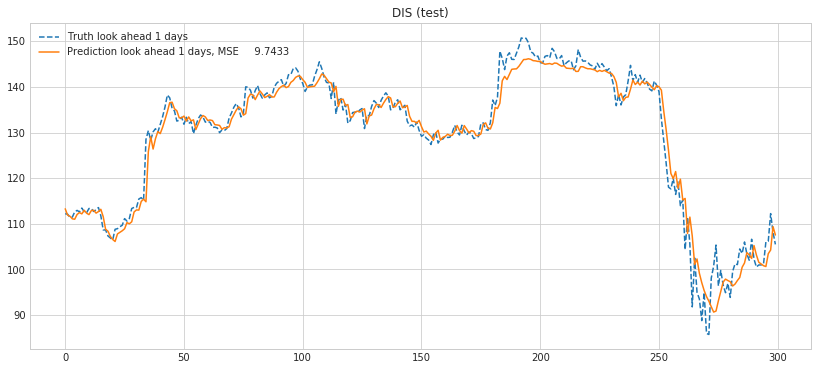

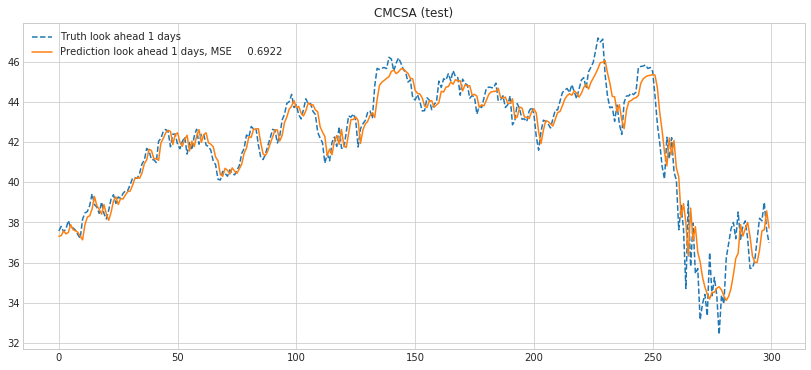

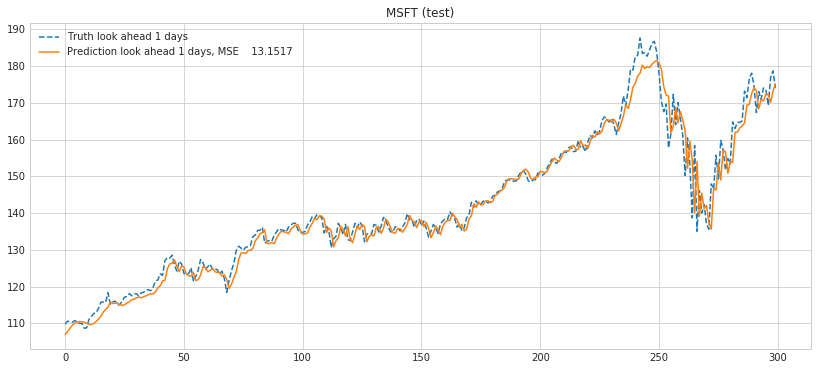

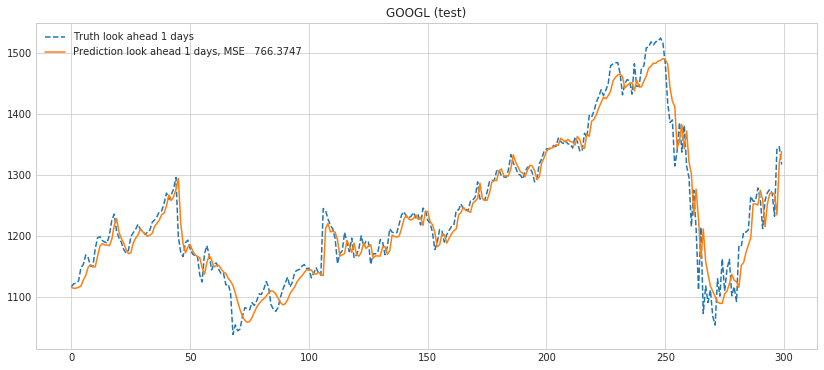

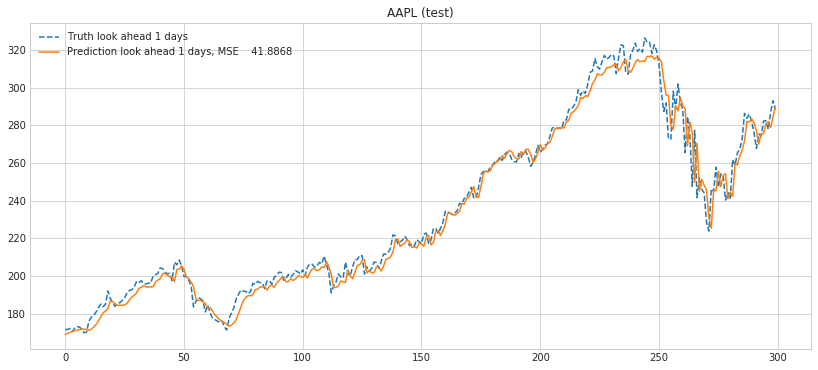

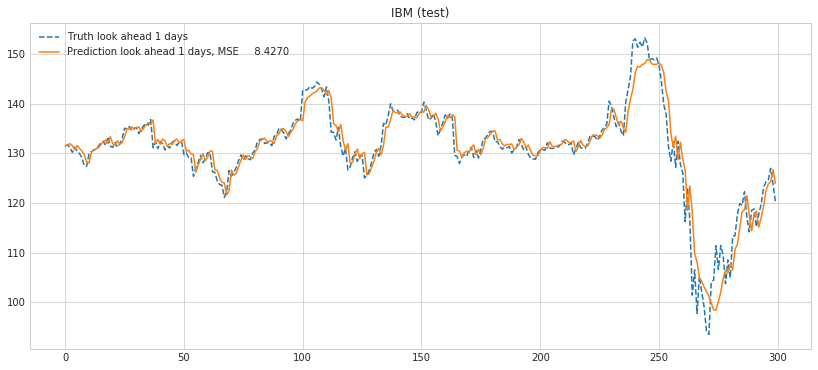

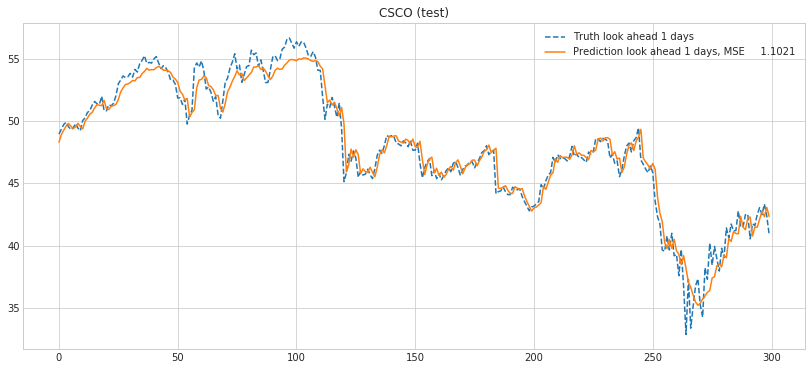

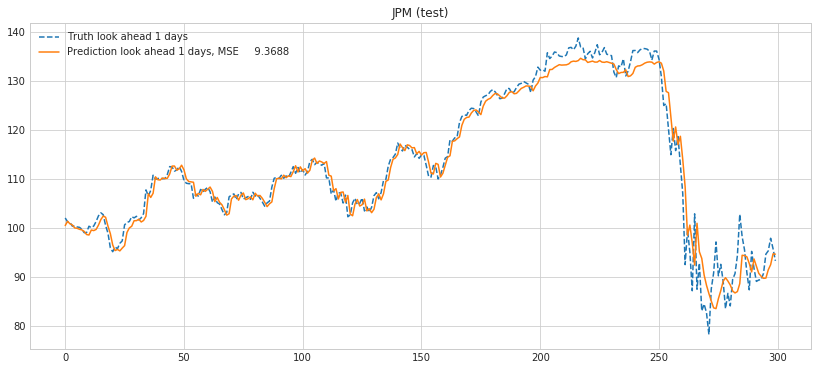

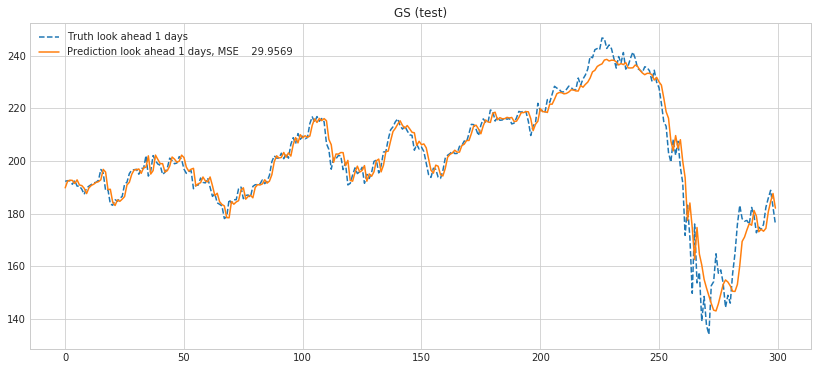

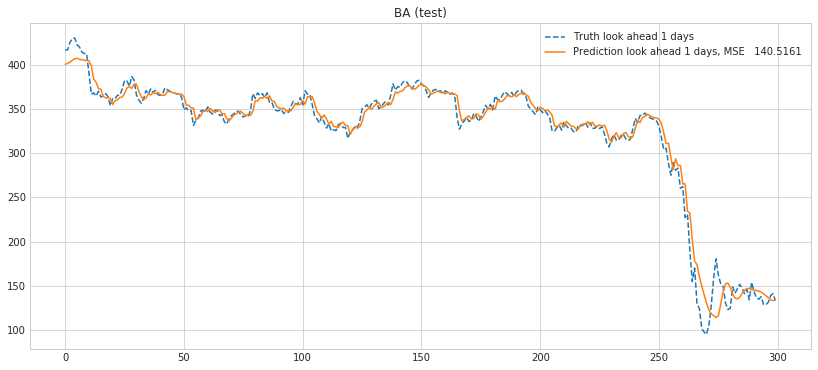

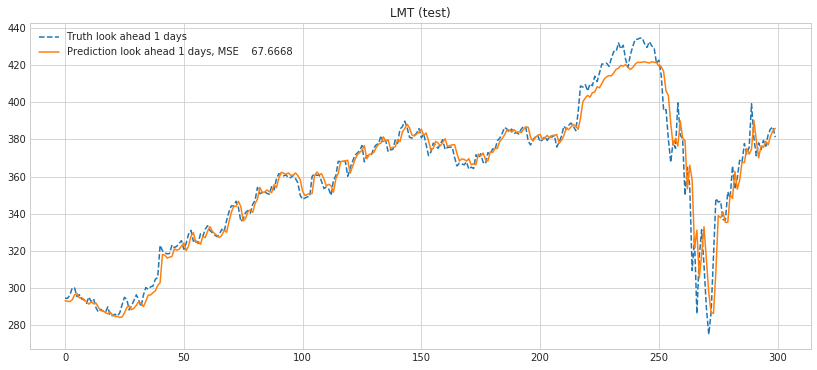

In [19]:
for ticker in tickers:
    eval.predict_and_plot(ds.test_dict, ticker, 'test', [1])

## Plot predictions and MSEs for lookahead 7 day

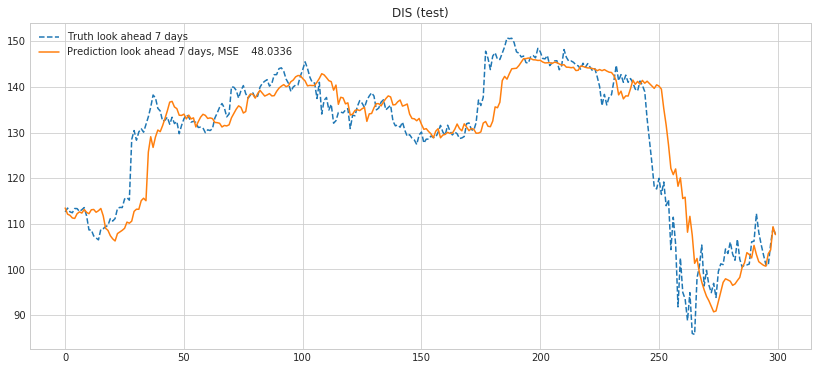

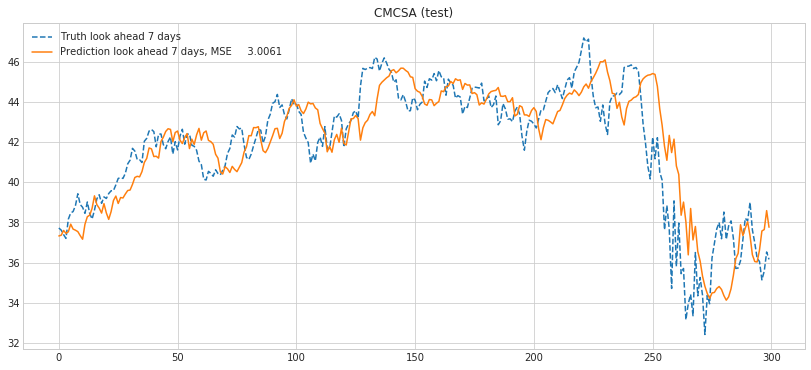

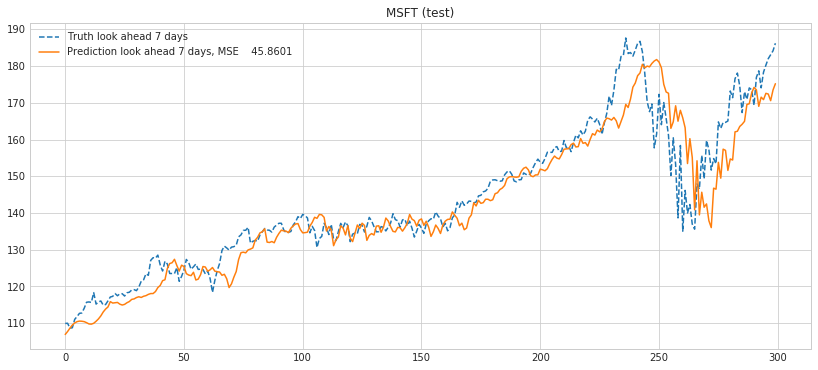

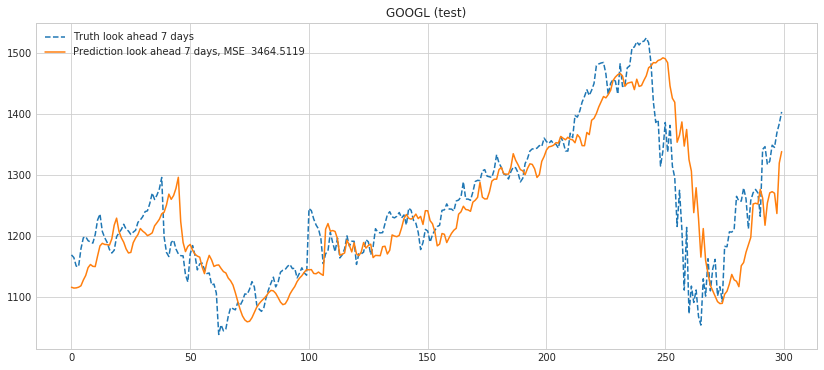

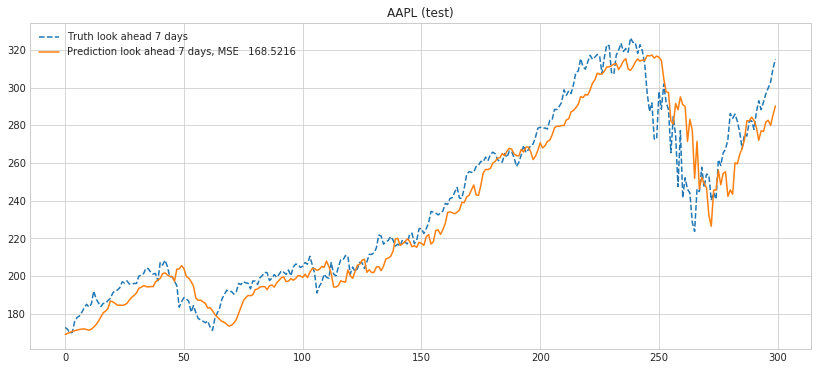

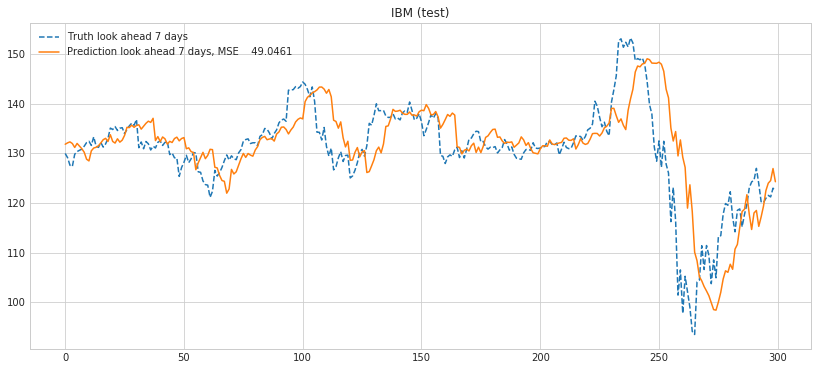

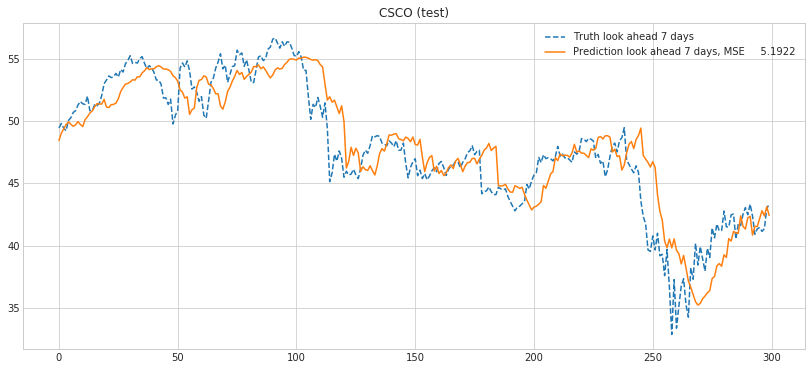

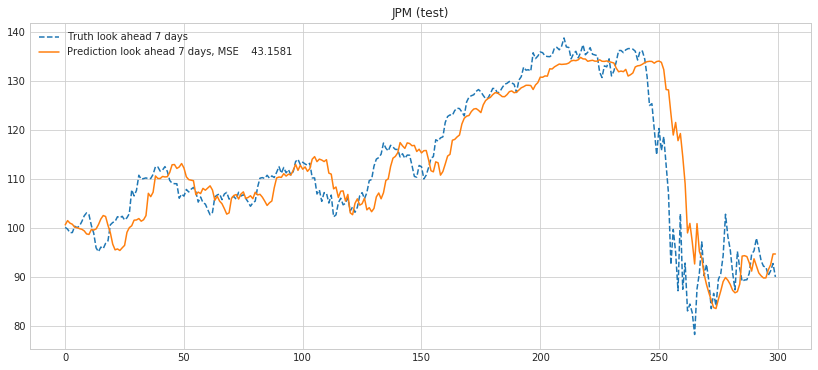

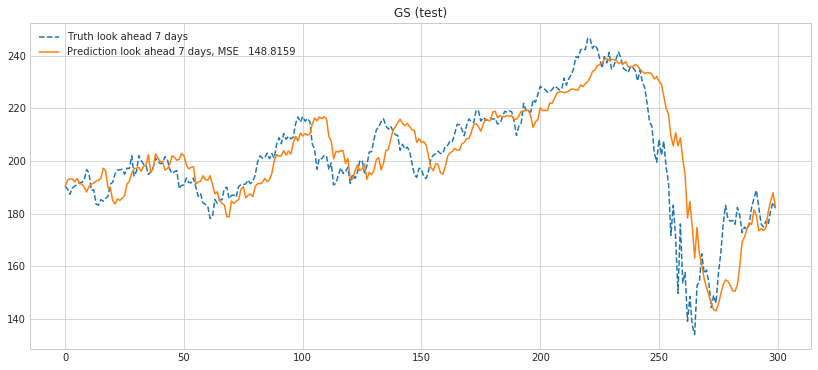

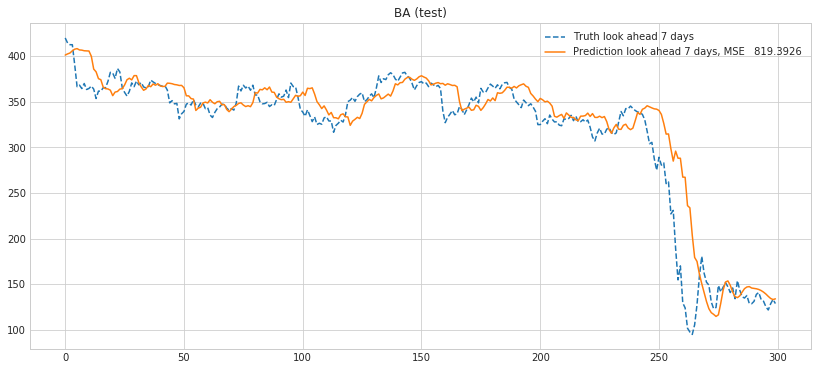

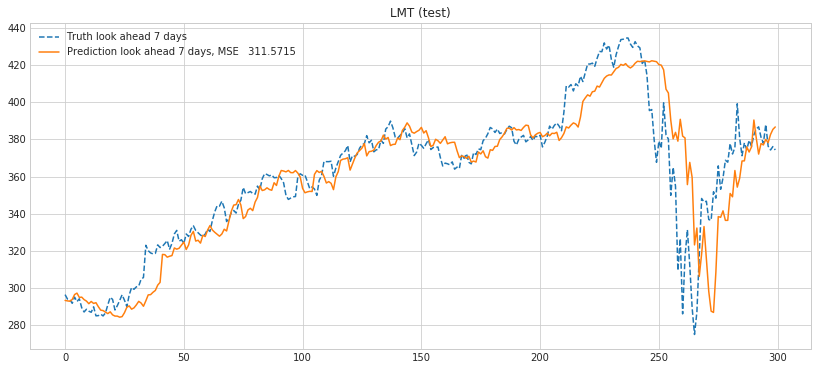

In [20]:
for ticker in tickers:
    eval.predict_and_plot(ds.test_dict, ticker, 'test', [7])

## Compare with benchmark models

In [21]:
eval.benchmark_MSE_comparison(ds.test_dict, tickers, 'test', [1, 3, 7])

,1,3,7
LSTM,98.9897,203.659,464.283
Last Value,82.293,188.448,447.69
MV,1084.4,1236.78,1540.27
LR,94.191,201.556,473.646
